#  پیش‌بینی تایید وام با استفاده از یادگیری ماشین

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from google.colab import files


In [3]:
#Upload and Load Data
uploaded = files.upload()
df = pd.read_csv('loan.csv')

Saving loan.csv to loan (2).csv


In [4]:
# Handle Missing Values
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

if cat_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

if num_cols:
    imputer_num = SimpleImputer(strategy='mean')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])


In [5]:
# Encode Categorical Columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])


In [6]:
# Feature Engineering
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Loan_Amount_Income_Ratio'] = df['LoanAmount'] / (df['Total_Income'] + 1)
df['EMI'] = df['LoanAmount'] / (df['Loan_Amount_Term'] + 1)
df['Total_Payment'] = df['EMI'] * df['Loan_Amount_Term']

In [7]:
# Separate Features and Labels
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']


In [8]:
# Update numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [9]:

# Split Dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2353, stratify=y_train_val, random_state=42)


In [10]:
# Standardization
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])


In [11]:
# Balance with SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train)


In [12]:
# GridSearch for KNN
knn_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}
knn_search = GridSearchCV(KNeighborsClassifier(), knn_grid, cv=5, scoring='f1')
knn_search.fit(X_resampled, y_resampled)
best_knn = knn_search.best_estimator_


In [13]:
# GridSearch for ANN
ann_grid = {
    'hidden_layer_sizes': [(10,), (10,10), (20,10)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'lbfgs'],   # اضافه شده
    'max_iter': [1500],            # افزایش تکرار
    'early_stopping': [True]       # فعال شدن توقف زودهنگام
}
ann_search = GridSearchCV(MLPClassifier(random_state=42), ann_grid, cv=3, scoring='f1')
ann_search.fit(X_resampled, y_resampled)
best_ann = ann_search.best_estimator_



===== Logistic Regression =====
Validation Report:
               precision    recall  f1-score   support

           0       0.55      0.58      0.56        38
           1       0.81      0.79      0.80        85

    accuracy                           0.72       123
   macro avg       0.68      0.68      0.68       123
weighted avg       0.73      0.72      0.73       123

Test Report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.71        29
           1       0.86      0.89      0.88        64

    accuracy                           0.83        93
   macro avg       0.80      0.79      0.80        93
weighted avg       0.83      0.83      0.83        93



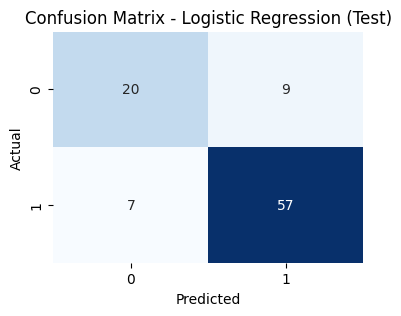


===== KNN (Tuned) =====
Validation Report:
               precision    recall  f1-score   support

           0       0.51      0.50      0.51        38
           1       0.78      0.79      0.78        85

    accuracy                           0.70       123
   macro avg       0.65      0.64      0.65       123
weighted avg       0.70      0.70      0.70       123

Test Report:
               precision    recall  f1-score   support

           0       0.61      0.66      0.63        29
           1       0.84      0.81      0.83        64

    accuracy                           0.76        93
   macro avg       0.73      0.73      0.73        93
weighted avg       0.77      0.76      0.77        93



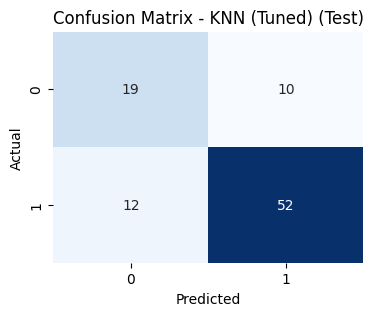


===== ANN (Tuned) =====
Validation Report:
               precision    recall  f1-score   support

           0       0.49      0.50      0.49        38
           1       0.77      0.76      0.77        85

    accuracy                           0.68       123
   macro avg       0.63      0.63      0.63       123
weighted avg       0.69      0.68      0.68       123

Test Report:
               precision    recall  f1-score   support

           0       0.57      0.59      0.58        29
           1       0.81      0.80      0.80        64

    accuracy                           0.73        93
   macro avg       0.69      0.69      0.69        93
weighted avg       0.73      0.73      0.73        93



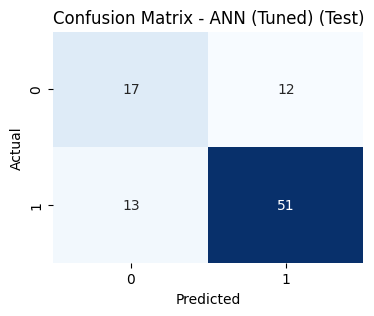

In [14]:
# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN (Tuned)": best_knn,
    "ANN (Tuned)": best_ann
}

# Evaluation Results
results = {
    'Model': [],
    'Set': [],
    'Accuracy': [],
    'F1 Score': []
}

# Train and Evaluate
for name, model in models.items():
    model.fit(X_resampled, y_resampled)

    val_preds = model.predict(X_val_scaled)
    results['Model'].append(name)
    results['Set'].append('Validation')
    results['Accuracy'].append(accuracy_score(y_val, val_preds))
    results['F1 Score'].append(f1_score(y_val, val_preds))

    test_preds = model.predict(X_test_scaled)
    results['Model'].append(name)
    results['Set'].append('Test')
    results['Accuracy'].append(accuracy_score(y_test, test_preds))
    results['F1 Score'].append(f1_score(y_test, test_preds))

    print(f"\n===== {name} =====")
    print("Validation Report:\n", classification_report(y_val, val_preds))
    print("Test Report:\n", classification_report(y_test, test_preds))

    cm = confusion_matrix(y_test, test_preds)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name} (Test)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
results_df = pd.DataFrame(results)

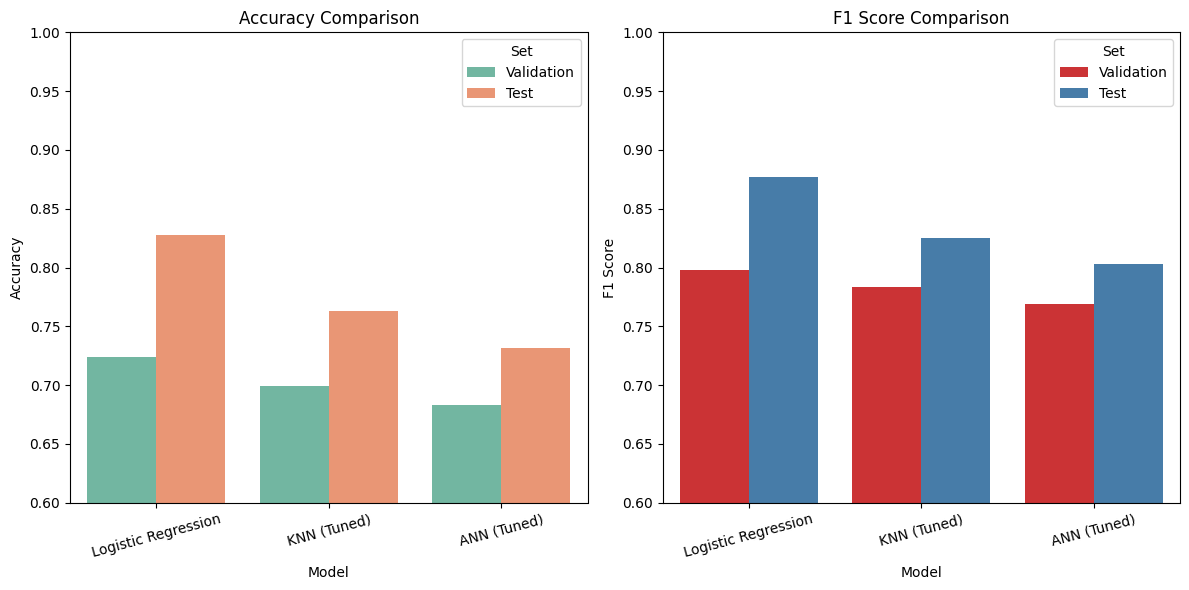

In [15]:
# Plot Accuracy & F1-score Comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Model', y='Accuracy', hue='Set', palette='Set2')
plt.title('Accuracy Comparison')
plt.ylim(0.6, 1.0)
plt.xticks(rotation=15)

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Model', y='F1 Score', hue='Set', palette='Set1')
plt.title('F1 Score Comparison')
plt.ylim(0.6, 1.0)
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()
